In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

The goodbooks-10k dataset is used from this link:
https://github.com/zygmuntz/goodbooks-10k
    
To run the project download the dataset and change the directory on the cell below.

In [2]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/goodbooks-10k-master/goodbooks-10k-master/ratings.csv')
books_df = pd.read_csv('C:/Users/papad/Desktop/goodbooks-10k-master/goodbooks-10k-master/books.csv')
to_read_df = pd.read_csv('C:/Users/papad/Desktop/goodbooks-10k-master/goodbooks-10k-master/to_read.csv')
book_tags_df = pd.read_csv('C:/Users/papad/Desktop/goodbooks-10k-master/goodbooks-10k-master/book_tags.csv')
tags_df = pd.read_csv('C:/Users/papad/Desktop/goodbooks-10k-master/goodbooks-10k-master/tags.csv')

# Dataset

In [3]:
percentage = 1.7
ratings_df = ratings_df.head(int(len(ratings_df)*(percentage/100)))

In [4]:
books_df[books_df['book_id']==9439]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
9438,9439,35539,35539,1654509,17,316013315,9.780316e+12,Bob Spitz,2005.0,The Beatles: The Biography,...,8120,8464,390,205,314,1270,3020,3655,https://images.gr-assets.com/books/1327951066m...,https://images.gr-assets.com/books/1327951066s...


In [5]:
ratings_df

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
101595,344,27,3
101596,344,21,3
101597,344,25,3
101598,344,23,3


In [6]:
num_users = ratings_df['user_id'].unique()
print(len(num_users))
num_items = ratings_df['book_id'].unique()
print(len(num_items))

1823
5050


# Spotlight

Spotlight users and items ids should be consecutive. For that purpose in the cell below, the defaultdict function from the collections library is used to provide, the uid_map and iid_map. These variables contain consecutive numbers equal to the number of users and items respectively. These are necessary to create the interaction objects, which are the fundamental objects of the Spotlight platform, and are required in order to build a Spotlight recommender. 

Then I keep the reveresed mapped user and item ids, to take the real predicted item ids when i finish the process with the Spotlight model.

In [7]:
from collections import defaultdict
from itertools import count
uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["user_id"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["book_id"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}


print("userId %d got uid %d" % (556, uid_map[556]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 556 got uid 1823
movieId 54001 got iid 5050


Interactions refer, to the user-item interactions. Each interaction contains a user-item pair interaction, and it can be added a timestamp, and for explicit models, a rating.

After creating the Interactions object I split the data using the random_train_test_split function from the Spotlight library. I firstly split my dataset into train set, test set, validation set. 
Having in mind that a lightGBM that combines the knowledge extracted from a few baseline models, I split the training set into features and label sets, to use them to formulate the data in order to train the lightGBM model later.

In [8]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  


#pecify the ids of the users and items for all the pairs of user-item interactions
implicit_interaction = Interactions(user_ids=uids,
                                   item_ids=iids)


#lets initialise the seed, so that its repeatable and reproducible 
implicit_train_tmp, implicit_test = random_train_test_split(implicit_interaction, random_state=np.random.seed(42))
implicit_train, implicit_val = random_train_test_split(implicit_train_tmp, random_state=np.random.seed(42))
implicit_train_features, implicit_train_labels = random_train_test_split(implicit_train, random_state=np.random.seed(42))

In [9]:
print(implicit_train)
print(implicit_test)
print(implicit_val)
print(implicit_train_features)
print(implicit_train_labels)

<Interactions dataset (1823 users x 5050 items x 65024 interactions)>
<Interactions dataset (1823 users x 5050 items x 20320 interactions)>
<Interactions dataset (1823 users x 5050 items x 16256 interactions)>
<Interactions dataset (1823 users x 5050 items x 52019 interactions)>
<Interactions dataset (1823 users x 5050 items x 13005 interactions)>


Apart from a Spotlight model, an SVD model is trained, so the conversion of the Interaction objects to dataframes is thought as necessary, as the same data should be used for all the model, to provide fair comparisons.

In [10]:
def interactionToDataFrame(dataset):
    converted_users = []
    converted_books = []
    rating = []
    for i in range(len(dataset.user_ids)):
        converted_users.append(uid_rev_map[dataset.user_ids[i]])
        converted_books.append(iid_rev_map[dataset.item_ids[i]])
        rating.append(float(ratings_df['rating'][(ratings_df['book_id'] == converted_books[i]) & (
            ratings_df['user_id'] == converted_users[i])].values))
    df = pd.DataFrame({'user_id': converted_users,
                       'book_id': converted_books, 'rating': rating})
    return df

In [11]:
train_df = interactionToDataFrame(implicit_train)
val_df = interactionToDataFrame(implicit_val)
test_df = interactionToDataFrame(implicit_test)
train_features_df = interactionToDataFrame(implicit_train_features)
train_labels_df = interactionToDataFrame(implicit_train_labels)

## Implicit Factorization model

The model form the Spotlight, that is used is the Implicit Factorization model. This is a model used to address implicit feedback from the users. To make it clear, the implicit feedback in a movie platform could be the movie that a user watched but did not gave a rating. Given, that he/ she watched some movies, knowledge can be extracted about his/her preferences, without having ratings.

In [12]:
implicit_model = ImplicitFactorizationModel(n_iter=5)

current = time.time()

implicit_model.fit(implicit_train, verbose=True)

end = time.time()
diff = end - current
print('Training took %d second' % (diff))

Epoch 0: loss 0.7867393846821598
Epoch 1: loss 0.46553867128421
Epoch 2: loss 0.40211350488381126
Epoch 3: loss 0.3483975711535281
Epoch 4: loss 0.30795419978813865
Training took 31 second


### Top - K

The idea is to provide the top-K(100) recommendations for each user and then evaluate the results using the NDCG evaluation metric. 

For this purpose on the cell below, the topK recommendations for a user are calculated.

The function below, topK_implicit, has been introduced on the lab of the course Recommender Systems.

In [13]:
import scipy.stats as st
k = 100
def topK_implicit(user, model, k=100):
  a= list()
  ranks = st.rankdata(-model.predict(user))   
  for iid in np.argwhere(ranks <= k):
    a.append(iid_rev_map[iid.item(0)])
  return a

rec_forUser = topK_implicit(0,implicit_model)
print(rec_forUser)

[26, 33, 301, 70, 18, 27, 21, 2, 23, 24, 255, 35, 287, 84, 58, 111, 5, 8, 65, 45, 113, 325, 14, 55, 36, 13, 50, 32, 28, 42, 249, 158, 184, 495, 350, 219, 11, 658, 101, 344, 372, 122, 9, 81, 60, 238, 795, 119, 587, 10, 76, 171, 94, 516, 115, 177, 4, 483, 326, 100, 92, 68, 557, 131, 284, 378, 130, 136, 78, 186, 398, 150, 114, 22, 7, 121, 217, 80, 228, 43, 57, 161, 155, 59, 29, 118, 354, 117, 19, 127, 38, 485, 335, 15, 457, 44, 25, 170, 46, 67]


The topK recommendations for all users are needed, so the function below returns the topK recommendations for all the users, taking advantage of the function above.

In [14]:
def allUsers_topK_implicit(model):
    a = []
    for i in range(len(num_users)):
       a.append(topK_implicit(i,model))
    return a

### NDCG Score

In [15]:
allUsers_topK_imp = allUsers_topK_implicit(implicit_model)

To provide the NDCG value it is necessary to compute the relevance for each user. The relevance containes 0s and 1s, based on which of the topK recommended movies the user has actually watched. For every recommended movie that the user has actually watched, the value of 1 is assigned. 

The function below returns a list that contains a relevance list for each user.

In [16]:
def relevance_spotlight_implicit(allUsers_topK):
    relevance_implicit_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(allUsers_topK[count])):
            if allUsers_topK[count][j] in test_df['book_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_implicit_full.append(helper)
        helper = []
        count += 1
    return relevance_implicit_full

The relevance_implicit_full variable contains the relevance list of each user for the implicit factorization model results.

In [17]:
relevance_implicit_full = relevance_spotlight_implicit(allUsers_topK_imp)

The dcg and ideal_dcg functions are taken form https://github.com/lezzago/LambdaMart/blob/master/lambdamart.py. They are necessary to compute the desired NDCG evaluation metric.

In [18]:
def dcg(scores):
    """
    Returns the DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    DCG_val: int
        This is the value of the DCG on the given scores
    """
    return np.sum([
                    (np.power(2, scores[i]) - 1) / np.log2(i + 2)
                    for i in range(len(scores))
                ])

In [19]:
def ideal_dcg(scores):
    """
    Returns the Ideal DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    Ideal_DCG_val: int
        This is the value of the Ideal DCG on the given scores
    """
    scores = [score for score in sorted(scores)[::-1]]
    return dcg(scores)

The function below, NDCG_forUser, given a relevance list, returns the NDCG value. In simpler words, it returns the NDCG value for a user.

In [20]:
def NDCG_forUser(relevance):
    return dcg(relevance) / ideal_dcg(relevance)

The function below, allUsers_ndcg, returns a list that contains the NDCG score for each user.

In [21]:
def allUsers_ndcg(relevance):
    allUsers_implicit_ndcg = []
    for i in range(len(num_users)):
        allUsers_implicit_ndcg.append(NDCG_forUser(relevance[i]))
    return allUsers_implicit_ndcg

In [22]:
allUsers_implicit_ndcg = allUsers_ndcg(relevance_implicit_full)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Fill the nan values with 0s.

In [23]:
allUsers_implicit_ndcg = pd.Series(allUsers_implicit_ndcg).fillna(0).tolist()

Compute the mean value of the NDCG scores.

In [24]:
np.array(allUsers_implicit_ndcg).mean()

0.1606677310602764

### MRR Score

In [25]:
#Calculate reciprocal rank. Where is the first relevant item?
def RR_forUsers(relevance):
    count = 0
    reciprocal_rank_perUser = []
    #for each user
    first_perUser = 0
    for rel in relevance:
        #for each item in a relevance list
        for r in rel:
            count += 1
            if r == 1:
                #1/position
                first_perUser = 1/count
                #stop the iteration. Only care about the first relevant item
                break
        reciprocal_rank_perUser.append(first_perUser)
        count = 0
    return reciprocal_rank_perUser

In [26]:
rr_implicit = RR_forUsers(relevance_implicit_full)

In [27]:
def calculate_mrr(rr):    
    #or np.array(rr).mean()
    return np.array(rr).sum()/len(rr)

In [28]:
implicit_mrr = calculate_mrr(rr_implicit)

In [29]:
implicit_mrr

0.1828667735353554

### MAP Score

In [30]:
#calculate average precision.
def calculate_averagePrecision(relevance):
    count_positive = 0
    positives = []
    ap_perUser = []
    count = 0
    #for each user
    for rel in relevance:
        #for each item in a relevance list
        for r in rel:
            count += 1
            if r == 1:
                count_positive += 1
                #First, second, etc. relevant item/ position
                positives.append(count_positive/count)
        #mean of relevant item/position
        ap_perUser.append(np.array(positives).sum()/count_positive)
        count_positive = 0
        positives = []
        count = 0
    return ap_perUser

In [31]:
implicit_ap = calculate_averagePrecision(relevance_implicit_full)
implicit_ap = pd.Series(implicit_ap).fillna(0).tolist()

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [32]:
def calculate_MAP(ap):
    #or np.array(ap).mean()
    return np.array(ap).sum()/len(ap)

In [33]:
implicit_map = calculate_MAP(implicit_ap)
implicit_map

0.05452826072426923

# SVD

On this section (Section 3), an SVD model is implemented, aiming to provide the top-K recommendations for each user and evaluate the results using the NDCG, MRR and MAP evaluation metrics.

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach, as it provides a dataframe in which, it can be seen directly any user-item rating.

In [34]:
df_book_features = train_df.pivot(
    index='user_id',
    columns='book_id',
    values='rating'
).fillna(0)

In [35]:
df_book_features

book_id,2,3,4,5,7,8,9,10,11,13,...,9981,9984,9985,9988,9990,9991,9995,9997,9998,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,4.0,4.0,0.0,4.0,0.0,5.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2996,5.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD implementation

In [36]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(df_book_features)

## Predictions

To get the prediction of a rating of an item dj, we can calculate the dot product of the two vectors.
The sigma variable has just the values, so I have to convert to a diagonal matrix in orded to implement the matrix multiplication.

In [37]:
sigma = np.diag(sigma)
svd_predictions_score = np.dot(np.dot(U, sigma), Vt)
svd_predictions_score_df = pd.DataFrame(svd_predictions_score, columns = df_book_features.columns)


In [38]:
svd_predictions_score_df

book_id,2,3,4,5,7,8,9,10,11,13,...,9981,9984,9985,9988,9990,9991,9995,9997,9998,10000
0,-1.714901e-03,1.215575e-04,-3.784375e-03,3.443688e-03,-3.939518e-03,3.197004e-03,-6.412489e-03,2.883366e-03,2.624190e-03,6.574947e-04,...,-9.970195e-05,-2.618302e-05,-1.182617e-04,-4.813396e-05,3.251818e-04,5.365072e-04,-1.062902e-04,2.135709e-05,3.665985e-05,-1.159335e-04
1,1.845206e-01,2.049052e-02,5.402305e-01,3.668301e-01,6.588254e-02,2.706324e-01,4.546532e-01,2.596974e-01,6.882387e-01,8.672763e-02,...,5.283505e-03,8.544035e-04,2.145540e-03,6.206460e-04,-7.288590e-04,2.055434e-03,3.437636e-03,-1.497639e-03,-2.067276e-03,2.497192e-03
2,3.858824e-02,4.184528e-03,7.357355e-01,6.389618e-01,3.038125e-01,6.718963e-01,1.800304e-01,4.049813e-01,2.514332e-01,5.312598e-01,...,3.209888e-03,1.254914e-03,2.826666e-04,1.069873e-02,7.905426e-04,1.146772e-02,1.085957e-02,1.787829e-03,2.203760e-03,7.642004e-03
3,3.582741e+00,2.195288e-01,3.163711e+00,2.652613e+00,1.708479e+00,2.408267e+00,1.664894e+00,2.387558e+00,1.553215e+00,1.949136e+00,...,1.792970e-02,3.348778e-03,1.024907e-02,2.526156e-02,-6.822548e-03,3.118388e-02,3.214809e-02,1.533192e-03,2.503057e-03,1.758384e-02
4,-6.186907e-17,-7.814040e-19,-5.142970e-17,-3.621171e-17,-6.938045e-17,-7.140410e-17,-1.127844e-17,-1.203244e-17,1.188742e-18,-8.006518e-17,...,1.622784e-19,1.840553e-21,-3.678623e-19,-1.367362e-18,-2.129330e-19,5.865715e-20,-1.769882e-19,-2.366450e-19,-2.754279e-19,-1.494404e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,2.189988e+00,1.199031e-01,3.877836e-01,3.062871e-01,1.827993e-01,-5.381448e-02,6.147459e-01,6.234350e-01,2.549936e-01,-8.694499e-03,...,5.736662e-03,-6.174308e-04,5.739633e-03,-7.393718e-03,-1.285378e-02,-9.347094e-03,-3.160116e-03,-3.553395e-03,-4.171631e-03,-3.410775e-03
1801,3.089146e+00,1.239018e-01,1.540623e+00,8.946599e-01,1.479798e+00,1.140228e+00,1.152468e+00,7.474185e-01,4.553886e-01,1.325050e+00,...,7.836667e-03,6.196484e-04,1.612972e-02,1.762671e-02,-1.822335e-02,-2.633840e-02,4.544058e-03,-6.669086e-04,-1.355283e-03,2.652066e-02
1802,6.490578e-02,1.545460e-02,7.043176e-01,8.349777e-01,1.956146e-01,1.058020e+00,2.899179e-01,3.597657e-01,1.534942e+00,6.117508e-01,...,-2.203006e-03,-1.038647e-03,-3.021055e-03,4.931797e-03,3.089203e-02,4.058547e-02,-7.659890e-03,2.372366e-04,3.132019e-04,7.011052e-03
1803,-7.136772e-03,1.183635e-03,2.992666e-03,7.644987e-06,-4.466118e-03,-1.452245e-03,2.020400e-02,8.710841e-04,5.542319e-02,-1.491002e-02,...,8.088281e-05,-9.271159e-06,-4.239476e-06,-4.756597e-04,6.667653e-04,4.656600e-04,-3.177350e-04,-1.348962e-04,-1.663891e-04,-3.880456e-04


In [39]:
svd_predictions_score_df[svd_predictions_score_df.index == 1137]

book_id,2,3,4,5,7,8,9,10,11,13,...,9981,9984,9985,9988,9990,9991,9995,9997,9998,10000
1137,1.652007,0.079335,0.787275,0.795693,0.432822,0.775529,0.436242,0.658725,0.605262,0.667633,...,0.001694,-0.000835,0.00281,0.005437,0.004378,0.014053,-0.002693,-0.000455,-0.000442,0.008502


## Top-K recommendations

The function below returns a list that contains the top-100 recommendations for each user

In [40]:
def SVD_topK_first(score_df):
    topK_svd_rec = []
    c = 0
    for i in range(len(svd_predictions_score_df)):
        svd_h_df = pd.DataFrame({'book_id': score_df[score_df.index == i].columns,
                                 'score': score_df[score_df.index == i].values[0]})
        svd_h_df = svd_h_df.sort_values('score', ascending=False)
        svd_h_df = svd_h_df.head(100)
        topK_svd_rec.append(svd_h_df['book_id'].values)
    return topK_svd_rec

## NDCG Score

The function below returns the relevance list of a list of books.

In [41]:
def SVD_relevance_first(score_df):
    svd_topK = SVD_topK_first(score_df)
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(svd_predictions_score_df)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count][j] in test_df['book_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full

In [42]:
relevance_first = SVD_relevance_first(svd_predictions_score_df)

In [43]:
np.asarray(relevance_first).shape

(1805, 100)

In [44]:
n_f = NDCG_forUser(relevance_first[0])

In [45]:
n_f

0.19271668197307076

Below is the NDCG scores of each user

In [46]:
def allUsers_ndcg_svd(relevance):
    allUsers_implicit_ndcg = []
    for i in range(len(svd_predictions_score_df)):
        allUsers_implicit_ndcg.append(NDCG_forUser(relevance[i]))
    return allUsers_implicit_ndcg
all_ndcg_f = allUsers_ndcg_svd(relevance_first)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [47]:
all_ndcg_f = pd.Series(all_ndcg_f).fillna(0).tolist()

In [48]:
np.asarray(all_ndcg_f).mean()

0.15446558092324822

## MRR Score

In [49]:
svd_rr = RR_forUsers(relevance_first)
svd_mrr = calculate_mrr(svd_rr)
svd_mrr

0.1818898492629772

## MAP Score

In [50]:
svd_ap = calculate_averagePrecision(relevance_first)
svd_ap = pd.Series(svd_ap).fillna(0).tolist()
svd_map = calculate_MAP(svd_ap)
svd_map

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


0.05281206366121188

# Feature engineering

##  Feature 1 (Implicit factorization model scores)

Train an implicit factorization model using the train_features dataset

In [51]:
f1_model = ImplicitFactorizationModel(n_iter = 5)

current = time.time()

f1_model.fit(implicit_train_features,verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))

Epoch 0: loss 0.844803140443914
Epoch 1: loss 0.49322137411902933
Epoch 2: loss 0.4191049173766491
Epoch 3: loss 0.3634341267101905
Epoch 4: loss 0.31827477782088165
Training took 24 second


### Target Books

In [52]:
def getImplicitTop():
    moviePerUser = []
    rev = []
    for user in range(len(num_users)):
        pred = f1_model.predict(user)
        #sort by score in descending order oscer
        predMovieId = np.argsort(-pred)
        #keep top 100
        predMovieId = predMovieId[:100]
        #reverse the mapping to get the original movieIDs
        for movie in predMovieId:
            rev.append(iid_rev_map[movie])
        moviePerUser.append(rev)
        rev = []
    return moviePerUser

In [53]:
target_positive = getImplicitTop()

Add negative samples to the target books

In [54]:
len(train_df['user_id'].unique())

1805

In [55]:
import random
target_negative = []
for i in range(1,len(num_users)+1):
    #get 50 random movieIDs for each user
    target_negative.append(random.choices(train_features_df['book_id'].values, k = 50))

In [56]:
target_movies = []
for i in range(len(num_users)):
    target_movies.append(target_positive[i] + target_negative[i])

Map the target books to pick the correct predictions based on the item id

In [57]:
def map_movies(target_movies):
    map_target_movies = []
    map_help = []
    for movies in target_movies:
        for movie in movies:
            map_help.append(iid_map[movie])
        map_target_movies.append(map_help)
        map_help = []
    return map_target_movies

Implicit Factorization model Scores

In [58]:
def give_movies_implicit_scores(map_movies):
    implicit_scores = 0
    feature = []
    for i in range(len(num_users)):
        #for movies in map_target_movies:
        my_list = map_movies[i]
        my_array = np.array(my_list)
        implicit_scores = f1_model.predict(user_ids = i,item_ids = my_array)
        feature.append(implicit_scores)
    return feature

In [59]:
map_target_movies = map_movies(target_movies)
feature1 = give_movies_implicit_scores(map_target_movies)
feature1 = np.asarray(feature1)
feature1.shape

(1823, 150)

In [60]:
feature1[0]

array([ 5.7252107 ,  5.463154  ,  5.3625426 ,  5.2988486 ,  5.2024007 ,
        5.1950197 ,  5.181392  ,  5.1166663 ,  5.0921307 ,  5.0090494 ,
        4.943444  ,  4.933306  ,  4.9086337 ,  4.8967314 ,  4.8740783 ,
        4.8738894 ,  4.867943  ,  4.853584  ,  4.8298182 ,  4.8093824 ,
        4.8084803 ,  4.789267  ,  4.742272  ,  4.7388964 ,  4.7267437 ,
        4.7245817 ,  4.7147336 ,  4.6966    ,  4.6939993 ,  4.6892467 ,
        4.6745224 ,  4.6740704 ,  4.6652994 ,  4.636307  ,  4.6350555 ,
        4.631917  ,  4.614517  ,  4.6036577 ,  4.6024575 ,  4.5977716 ,
        4.588028  ,  4.5773554 ,  4.573977  ,  4.5606613 ,  4.556697  ,
        4.5555725 ,  4.52922   ,  4.519529  ,  4.5115204 ,  4.5095925 ,
        4.5060353 ,  4.504498  ,  4.4972725 ,  4.4899745 ,  4.4782844 ,
        4.4598026 ,  4.4561143 ,  4.45506   ,  4.447013  ,  4.442402  ,
        4.428132  ,  4.420966  ,  4.417607  ,  4.417477  ,  4.4174476 ,
        4.4094987 ,  4.399986  ,  4.398423  ,  4.3931866 ,  4.39

## Feature 2 (Spotlight Rank)

In [61]:
feature2 = []
for i in range(len(num_users)):
    feature2 = (st.rankdata(-f1_model.predict(i)))
    feature2 = feature2[map_target_movies]
    feature2.sort()

In [62]:
np.array(feature2).shape

(1823, 150)

In [63]:
feature2[0]

array([1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 6.000e+00,
       8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01, 1.200e+01, 1.300e+01,
       1.500e+01, 1.600e+01, 1.700e+01, 1.800e+01, 1.800e+01, 1.900e+01,
       2.100e+01, 2.200e+01, 2.300e+01, 2.400e+01, 2.500e+01, 2.500e+01,
       2.600e+01, 2.800e+01, 3.000e+01, 3.200e+01, 3.300e+01, 3.600e+01,
       3.700e+01, 3.700e+01, 3.700e+01, 4.000e+01, 4.100e+01, 4.200e+01,
       4.200e+01, 4.500e+01, 4.600e+01, 4.700e+01, 5.100e+01, 5.200e+01,
       5.500e+01, 5.600e+01, 5.700e+01, 6.000e+01, 6.000e+01, 6.100e+01,
       6.300e+01, 6.400e+01, 6.500e+01, 6.700e+01, 7.100e+01, 7.300e+01,
       8.500e+01, 8.900e+01, 9.600e+01, 9.900e+01, 1.000e+02, 1.010e+02,
       1.090e+02, 1.100e+02, 1.120e+02, 1.150e+02, 1.210e+02, 1.220e+02,
       1.250e+02, 1.260e+02, 1.270e+02, 1.290e+02, 1.400e+02, 1.440e+02,
       1.520e+02, 1.520e+02, 1.540e+02, 1.590e+02, 1.640e+02, 1.650e+02,
       1.680e+02, 1.700e+02, 1.740e+02, 1.900e+02, 

## Feature 3 (SVD scores)

SVD model Scores. Take advantage of the DataFrame containing the scores to extract the predicted scores for the desired books.

In [64]:
df_movie_features1 = train_features_df.pivot(
    index='user_id',
    columns='book_id',
    values='rating'
).fillna(0)

In [72]:
len(df_movie_features1)

1792

In [65]:
df_movie_features1

book_id,2,3,4,5,7,8,9,10,11,13,...,9981,9984,9985,9988,9990,9991,9995,9997,9998,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,4.0,4.0,0.0,4.0,0.0,5.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2995,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2996,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
U1, sigma1, Vt1 = svds(df_movie_features1)
sigma1 = np.diag(sigma1)
svd_predictions_score1 = np.dot(np.dot(U1, sigma1), Vt1)
svd_predictions_score_df1 = pd.DataFrame(svd_predictions_score1, columns = df_movie_features1.columns)

In [67]:
svd_predictions_score_df1[svd_predictions_score_df1.index == 1]

book_id,2,3,4,5,7,8,9,10,11,13,...,9981,9984,9985,9988,9990,9991,9995,9997,9998,10000
1,0.029234,0.011712,0.199912,0.19072,-0.003823,0.131809,0.156415,0.146184,0.340464,0.018474,...,0.002272,0.000317,0.000044,0.000845,0.001792,0.002402,0.001326,-0.000704,-0.000686,-0.000649


In [68]:
len(num_users)

1823

In [69]:
float(svd_predictions_score_df1[svd_predictions_score_df1.index == 0][target_movies[0][0]].values)

0.004980873082265228

In [73]:
feature3 = []
feature3_user = []
count = 0
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        if (target_movies[i][j] not in svd_predictions_score_df1[svd_predictions_score_df1.index == i]) or (i >= len(df_movie_features1)):
            feature3_user.append(0)
        else:
            feature3_user.append(float(svd_predictions_score_df1[svd_predictions_score_df1.index == i][target_movies[i][j]].values))
    feature3.append(feature3_user)
    feature3_user = []

In [74]:
np.array(feature3).shape

(1823, 150)

## Feature 5 (#Users watched each target movie)

In [75]:
number_views = []
number_view_per_movie = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['book_id'] == target_movies[i][j]]['user_id'])
        number_view_per_movie.append(a)
    number_views.append(number_view_per_movie)
    number_view_per_movie = []


In [76]:
feature5 = number_views

In [77]:
np.array(feature5).shape

(1823, 150)

## Feature 6 (New user)

In [78]:
len(ratings_df[ratings_df['user_id']==1]) > 10

False

In [79]:
new_users_binary = []
binary_per_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['user_id']==1]) > 10
        if a:
            binary_per_user.append(1)
        else:
            binary_per_user.append(0)
    new_users_binary.append(binary_per_user)
    binary_per_user = []

In [80]:
#rankings of old/new users

In [81]:
feature6 = new_users_binary

In [82]:
np.array(feature6).shape

(1823, 150)

## Feature 7(Embeddings) x32

In [83]:
emb = f1_model._net.item_embeddings

In [84]:
emb_features = []
helper = []
for i in range(32):
    for j in range(len(num_items)):
        helper.append(emb.weight[j][i].item())
    emb_features.append(helper)
    helper = []

In [85]:
a = []
b = []
feature7 = []
for i in range(32):
    for user in range(len(num_users)):
        for movie in map_target_movies[user]:
            a.append(emb_features[0][movie])
        b.append(a)
        a = []
    feature7.append(b)
    b = []

In [86]:
np.array(feature7).shape

(32, 1823, 150)

In [87]:
np.array(feature7[0]).shape

(1823, 150)

## Feature 47 (SVD Rank)

In [88]:
feature47 = []
for i in range(len(num_users)):
    feature47.append((st.rankdata(-np.array(feature3[i]))))

In [89]:
np.array(feature47).shape

(1823, 150)

In [90]:
feature47[0]

array([ 24. ,  37. ,  77. ,  18. ,  42. , 140. ,   8.5, 145. ,  38. ,
        95. ,  10. ,  68. , 141. ,  16. ,  20. ,   2. ,  12. ,  19. ,
         5.5, 146. ,  76. ,  35. ,  62. ,  31. ,  36. , 150. ,  91. ,
        27. ,  80. ,  87. ,  61. ,  96. ,  81. ,  15. ,  21. ,  13.5,
        67. ,   3. ,  55. ,  26. ,  90. ,  45. ,  93. ,  11. ,  46. ,
       144. ,  79. ,  53.5,  85.5,  72. , 142.5,  65. ,  97. ,   1. ,
        88. , 102. ,   7. ,  51. ,  52. ,  34. ,  92. , 147. ,  69. ,
        17. , 134. ,  40.5, 100. ,  78. ,  30. ,  82. ,  63. ,  58. ,
        32. ,  73.5,  56. , 149. ,  23. ,  48. , 106. ,  22. , 127. ,
       107. ,  28. ,  57. , 104. ,  50. ,  70. ,  25. ,  29. ,  64. ,
       109. ,  33. ,  66. ,  44. ,  59. , 111. ,  43. ,   4. ,  39. ,
        47. , 105. , 136. , 137. ,  49. , 100. , 123. , 110. ,  84. ,
       138. , 126. ,  73.5, 124. ,   5.5, 135. ,  40.5,  89. , 118. ,
        60. ,  13.5, 115. , 108. , 114. ,  53.5, 100. , 117. , 133. ,
       142.5,  85.5,

## Features stack

In [91]:
features = np.stack((feature1,feature2,feature3,feature5,feature6,
                     feature7[0], feature7[1],feature7[2], feature7[3],
                     feature7[4], feature7[5],feature7[6], feature7[7],
                     feature7[8], feature7[9],feature7[10], feature7[11],
                     feature7[12], feature7[13],feature7[14], feature7[15],
                     feature7[16], feature7[17],feature7[18], feature7[19],
                     feature7[20], feature7[21],feature7[22], feature7[23],
                     feature7[24], feature7[25],feature7[26], feature7[27],
                     feature7[28], feature7[29],feature7[30], feature7[31], feature47))

In [93]:
len(features)

38

## Labels

Below are the books that each user read

In [94]:
def watched_movies(df):
    watched = []
    #for i in range(len(num_users)):
    for u in uid_rev_map:
        watched.append(df[df["user_id"]==uid_rev_map.get(u)].groupby("book_id")["book_id"].count().index.tolist())  
    return watched 

In [95]:
#train_labels_df
#test_df
#val_df
train_watched = watched_movies(train_labels_df)
test_watched = watched_movies(test_df)
val_watched = watched_movies(val_df)

Creation of the target list. It containes 0s and 1s for the 100 recommended books for each user. Based on the read books it assigns the values. If the user read the recommended book, then the value of the target is equal to 1, otherwise it is 0.

In [96]:
def create_target(watched):
    user_target = []
    target = []
    for i in range(len(num_users)):
        for target_movie in target_movies[i]:
            if target_movie in watched[i]:
                user_target.append(1)
            else:
                user_target.append(0)
        target.append(user_target)
        user_target = []
    return target

In [97]:
label_train = create_target(train_watched)
label_test = create_target(test_watched)
label_val = create_target(val_watched)
#y_train = y_test = y_val

# LightGBM model

## Prepare X, y

Prepare data to be in the required input form for the LightGBM

In [98]:
k = len(target_movies[0])

X = np.array(features)
#X = X.reshape(len(num_users)*k,len(features))
X = X.reshape(len(features), len(num_users)*k)
X = np.transpose(X)
label_train = np.array(label_train)
label_test = np.array(label_test)
label_val = np.array(label_val)

In [99]:
y_train = label_train.reshape(len(num_users)*k,)
y_test = label_test.reshape(len(num_users)*k,)
y_val = label_val.reshape(len(num_users)*k,)

X_train
X_test
X_val
y_train
y_test
y_val

In [101]:
X_train = X
X_test = X
X_val = X

## Classifier

In [102]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

In [103]:
p = 0
m = k
clf_pred_per_user = []
for i in range(len(num_users)):
    clf_pred_per_user.append(y_pred[p:m])
    p += k
    m += k

In [104]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9739


In [105]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    266330
           1       0.00      0.00      0.00      7120

    accuracy                           0.97    273450
   macro avg       0.49      0.50      0.49    273450
weighted avg       0.95      0.97      0.96    273450



In [106]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9831
Test set score: 0.9739


The training and test set accuracy are quite comparable. So, we cannot say there is overfitting.

In [107]:
lgbm_clf_ndcg = NDCG_forUser(y_pred)

In [108]:
lgbm_clf_ndcg

0.15915801972875068

In [109]:
clf_rr = RR_forUsers(clf_pred_per_user)
clf_rr = pd.Series(clf_rr).fillna(0).tolist()

In [110]:
clf_MRR = calculate_mrr(clf_rr)

In [111]:
clf_MRR

0.022252643497624087

In [112]:
clf_ap = calculate_averagePrecision(clf_pred_per_user)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [113]:
clf_ap = pd.Series(clf_ap).fillna(0).tolist()
clf_map = calculate_MAP(clf_ap)
clf_map

0.00017017964645347046

## Ranker

In [114]:
import lightgbm as lgb
param = {
    "task": "train",
    "num_leaves": 255,
    "min_data_in_leaf": 1,
    "min_sum_hessian_in_leaf": 100,
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [1, 5, 10, 20],
    "learning_rate": .1,
    "num_threads": 2
}
gbm = lgb.LGBMRanker()
gbm.set_params(**param)

LGBMRanker(metric='ndcg', min_data_in_leaf=1, min_sum_hessian_in_leaf=100,
           ndcg_eval_at=[1, 5, 10, 20], num_leaves=255, num_threads=2,
           objective='lambdarank', task='train')

target movies
train_df
feature1
feature2

In [116]:
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]
group_train = []
group_val = []
print(query_train)
print(query_val)
print(query_test)

for i in range(len(num_users)):
    group_train.append(k)
    group_val.append(k)


[273450]
[273450]
[273450]


In [117]:
gbm.fit(X_train, y_train, group=group_train,
        eval_set=[(X_val, y_val)], eval_group=[group_val],
        eval_at=[1, 3, 5, 10], eval_metric='ndcg')
#no early stopping

[1]	valid_0's ndcg@1: 0.270433	valid_0's ndcg@3: 0.275507	valid_0's ndcg@5: 0.279999	valid_0's ndcg@10: 0.29761
[2]	valid_0's ndcg@1: 0.272079	valid_0's ndcg@3: 0.277654	valid_0's ndcg@5: 0.283458	valid_0's ndcg@10: 0.30536
[3]	valid_0's ndcg@1: 0.280856	valid_0's ndcg@3: 0.280704	valid_0's ndcg@5: 0.286518	valid_0's ndcg@10: 0.304025
[4]	valid_0's ndcg@1: 0.28305	valid_0's ndcg@3: 0.282292	valid_0's ndcg@5: 0.287883	valid_0's ndcg@10: 0.306509
[5]	valid_0's ndcg@1: 0.282501	valid_0's ndcg@3: 0.280933	valid_0's ndcg@5: 0.288988	valid_0's ndcg@10: 0.307618
[6]	valid_0's ndcg@1: 0.285793	valid_0's ndcg@3: 0.283814	valid_0's ndcg@5: 0.288482	valid_0's ndcg@10: 0.308783
[7]	valid_0's ndcg@1: 0.277564	valid_0's ndcg@3: 0.28244	valid_0's ndcg@5: 0.288036	valid_0's ndcg@10: 0.308137
[8]	valid_0's ndcg@1: 0.273725	valid_0's ndcg@3: 0.279511	valid_0's ndcg@5: 0.285058	valid_0's ndcg@10: 0.305638
[9]	valid_0's ndcg@1: 0.277016	valid_0's ndcg@3: 0.277936	valid_0's ndcg@5: 0.286592	valid_0's ndcg@

LGBMRanker(metric='ndcg', min_data_in_leaf=1, min_sum_hessian_in_leaf=100,
           ndcg_eval_at=[1, 5, 10, 20], num_leaves=255, num_threads=2,
           objective='lambdarank', task='train')

In [118]:
gbm.best_iteration_

In [119]:
test_pred = gbm.predict(X_test)
test_pred

array([-0.52151633, -0.89638419, -0.7744866 , ...,  0.46900885,
       -0.24932478, -2.31191023])

## NDCG Score

In [120]:
p = 0
m = 150
lgbm_pred_per_user = []
for i in range(len(num_users)):
    lgbm_pred_per_user.append(test_pred[p:m])
    p += 150
    m += 150

### NDCG IFM on this data

In [121]:
lgbm_NDCG = []
IFM_NDCG = []
SVD_NDCG = []
ifm_relevance_list = []
svd_relevance_list = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                             'implicit_rank': feature2[i], 'svd_score':feature3[i], '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i], 'svd_rank': feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
    excel_df = excel_df.sort_values('implicit_score', ascending=False)
    ifm_relevance = excel_df['test_label'].values.tolist()
    ifm_relevance_list.append(ifm_relevance)
    IFM_NDCG.append(NDCG_forUser(ifm_relevance))
    excel_df = excel_df.sort_values('svd_score', ascending=False)
    svd_relevance_h = excel_df['test_label'].values.tolist()
    svd_relevance_list.append(svd_relevance_h)
    SVD_NDCG.append(NDCG_forUser(svd_relevance_h))

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [122]:
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
IFM_NDCG = pd.Series(IFM_NDCG).fillna(0).tolist()
SVD_NDCG = pd.Series(SVD_NDCG).fillna(0).tolist()

# Comparisons

## NDCG 

In [123]:
ndcg_df = pd.DataFrame({'LightGBM': lgbm_NDCG, 'IFM_this': IFM_NDCG, 'SVD_this': SVD_NDCG})

In [124]:
ndcg_df

,LightGBM,IFM_this,SVD_this
0,0.183570,0.222665,0.196749
1,0.000000,0.000000,0.000000
2,0.477413,0.440223,0.346619
3,0.000000,0.000000,0.000000
4,0.244881,0.378002,0.179973
...,...,...,...
1818,0.274440,0.257033,0.242369
1819,0.376200,0.367470,0.305542
1820,0.000000,0.000000,0.000000
1821,0.000000,0.000000,0.000000


In [125]:
lgbm_mean = ndcg_df['LightGBM'].mean()
lgbm_mean

0.2811663685293966

In [126]:
ifm_mean = ndcg_df['IFM_this'].mean()
ifm_mean

0.28514917913054344

In [127]:
svd_mean = ndcg_df['SVD_this'].mean()
svd_mean

0.26793787783209794

## MRR

In [128]:
ifm_rr = RR_forUsers(ifm_relevance_list)
ifm_mrr = calculate_mrr(ifm_rr)
svd_rr = RR_forUsers(svd_relevance_list)
svd_mrr = calculate_mrr(svd_rr)
lgbm_rr = RR_forUsers(lgbm_relevance_list)
lgbm_mrr = calculate_mrr(lgbm_rr)

In [129]:
print('IFM:',ifm_mrr)
print('SVD:',svd_mrr)
print('LightGBM:',lgbm_mrr)

IFM: 0.1677689930442386
SVD: 0.15799582386281288
LightGBM: 0.17635027322320065


## MAP

In [130]:
ifm_ap = calculate_averagePrecision(ifm_relevance_list)
ifm_ap = pd.Series(ifm_ap).fillna(0).tolist()
ifm_map = calculate_MAP(ifm_ap)
svd_ap = calculate_averagePrecision(svd_relevance_list)
svd_ap = pd.Series(svd_ap).fillna(0).tolist()
svd_map = calculate_MAP(svd_ap)
lgbm_ap = calculate_averagePrecision(lgbm_relevance_list)
lgbm_ap = pd.Series(lgbm_ap).fillna(0).tolist()
lgbm_map = calculate_MAP(lgbm_ap)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [131]:
print('IFM:',ifm_map)
print('SVD:',svd_map)
print('LightGBM:',lgbm_map)

IFM: 0.09082615297760298
SVD: 0.0757962267994511
LightGBM: 0.08461781563540655


## Visualization

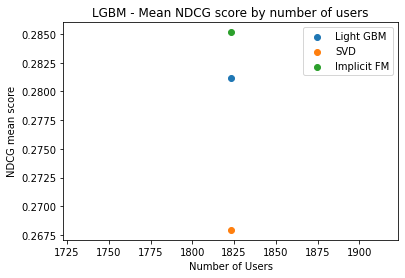

In [132]:
plt.scatter(len(num_users),lgbm_mean,label = 'Light GBM')
plt.scatter(len(num_users),svd_mean, label = 'SVD')
plt.scatter(len(num_users),ifm_mean, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('NDCG mean score')
plt.title('LGBM - Mean NDCG score by number of users')
plt.legend()

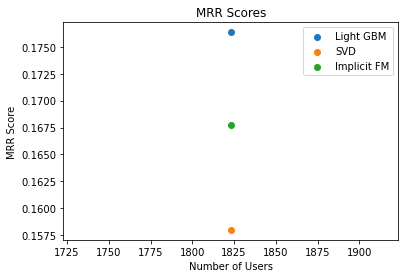

In [133]:
plt.scatter(len(num_users),lgbm_mrr,label = 'Light GBM')
plt.scatter(len(num_users),svd_mrr, label = 'SVD')
plt.scatter(len(num_users),ifm_mrr, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('MRR Score')
plt.title('MRR Scores')
plt.legend()

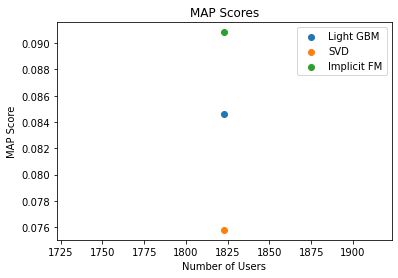

In [134]:
plt.scatter(len(num_users),lgbm_map,label = 'Light GBM')
plt.scatter(len(num_users),svd_map, label = 'SVD')
plt.scatter(len(num_users),ifm_map, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('MAP Score')
plt.title('MAP Scores')
plt.legend()

## Feature Importance

In [135]:
feature_names = excel_df.columns.values[1:39]

In [136]:
len(feature_names)

38

In [137]:
len(gbm.feature_importances_)

38

Text(0.5, 1.0, 'Importance of Features')

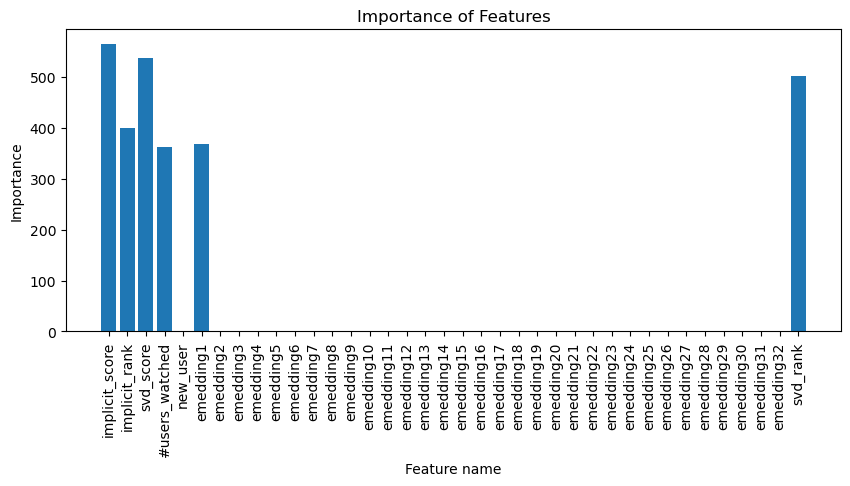

In [138]:
from matplotlib.pyplot import figure
figure(figsize=(10, 4),dpi=100)
plt.bar(feature_names,gbm.feature_importances_)
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Importance of Features')

In [139]:
gbm.feature_importances_

array([565, 400, 538, 362,   0, 369,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 501])

# Research Questions

## Research Question functions

The same procedure is implemented for all the experiments, so the functions below are created to provide robustness to the system and avoide any possible mistakes. Moreover, the code is much cleaner using the functions below.

The prepareXY function takes as input the features and returns input in the form that LightGBM requires

In [140]:
def prepareXY(features):
    X = np.array(features)
    #X = X.reshape(len(num_users)*k,len(features))
    X = X.reshape(len(features), len(num_users)*k)
    X = np.transpose(X)
    X_train = X
    X_test = X
    X_val = X
    return X_train, X_test, X_val

The lgbm_fit_predict function implements the training of the LightGBM model and provides the predictions of it.

In [141]:
def lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test):
    gbm.fit(X_train, y_train, group=group_train,
            eval_set=[(X_val, y_val)], eval_group=[group_val],
            eval_at=[1, 3, 5, 10], eval_metric='ndcg',verbose=0)
    #print(gbm.best_iteration_)
    test_pred = gbm.predict(X_test)
    p = 0
    m = k
    lgbm_pred_per_user = []
    for i in range(len(num_users)):
        lgbm_pred_per_user.append(test_pred[p:m])
        p += k
        m += k
    return lgbm_pred_per_user,gbm.feature_importances_

The plot_feature_importancesc function is used for the visualization of the feature importances

In [472]:
def plot_feature_importances(features, importances):
    feature_names = excel_df.columns[1:len(features)+1]
    print(feature_names)
    print(len(feature_names))
    print(len(importances))
    df=pd.DataFrame({'allvarlist': feature_names,'importances':importances})
    df.sort_values('importances',inplace=True)
    df = df[(df.T != 0).all()]
    figure(figsize=(10, 4), dpi=100)
    plt.barh(df['allvarlist'], df['importances'])
    #plt.xticks(rotation='vertical')
    plt.ylabel('Feature name')
    plt.xlabel('Importance')
    plt.title('Importance of Features')

The mrr_map function calculates and returns the MRR and MAP scores, given a relevance list

In [261]:
def mrr_map(lgbm_relevance_list):
    lgbm_rr = RR_forUsers(lgbm_relevance_list)
    lgbm_mrr = calculate_mrr(lgbm_rr)
    lgbm_ap = calculate_averagePrecision(lgbm_relevance_list)
    lgbm_ap = pd.Series(lgbm_ap).fillna(0).tolist()
    lgbm_map = calculate_MAP(lgbm_ap)
    return lgbm_mrr, lgbm_map, lgbm_rr, lgbm_ap

The compare_metrics function returns a DataFrame that contains the comparison of the NDCG, MRR and MAP metrics.

In [144]:
def compare_metrics(lgbm_NDCG, lgbm_MRR, lgbm_MAP):
    df = pd.DataFrame({'LightGBM_NDCG': lgbm_NDCG, 'IFM_NDCG': ifm_mean, 'SVD_NDCG': svd_mean,
                            'LightGBM_MRR': lgbm_MRR, 'IFM_MRR': ifm_mrr, 'SVD_MRR': svd_mrr,
                            'LightGBM_MAP': lgbm_MAP, 'IFM_MAP': ifm_map, 'SVD_MAP': svd_map},index=[0])
    return df

## All features

In [519]:
import scipy.stats as st
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature47))

In [520]:
len(features)

38

In [521]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

In [522]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i], 'svd_rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_all_features = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.2811663685293966

In [523]:
lgbm_mrr, lgbm_map, lgbm_rr_all_features, lgbm_ap_all_features = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [525]:
print(st.ttest_rel(ifm_rr,lgbm_rr_all_features))

Ttest_relResult(statistic=-1.2482131418521298, pvalue=0.212113388758941)


In [526]:
print(st.ttest_rel(ifm_ap,lgbm_ap_all_features))

Ttest_relResult(statistic=2.4317085599119523, pvalue=0.015123596542097899)


In [527]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [528]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.281166,0.285149,0.267938,0.17635,0.167769,0.157996,0.084618,0.090826,0.075796


In [529]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'svd_rank'],
      dtype='object')
38
38


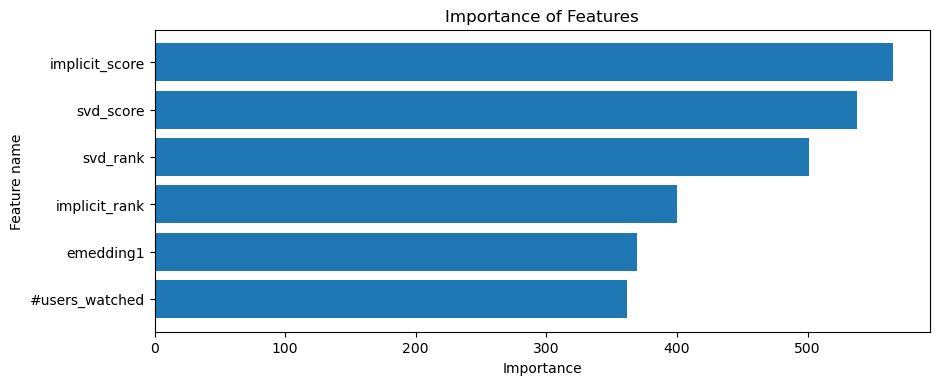

In [530]:
plot_feature_importances(features, importances)

In [531]:
importances

array([565, 400, 538, 362,   0, 369,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 501])

## What is the impact of items' embeddings features on the effectiveness of a model for item recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 


### No item embeddings features

In [458]:
features = np.stack((feature1,feature2,feature3,feature5,feature6,feature47))

In [459]:
len(features)

6

In [460]:
X_train, X_test, X_val = prepareXY(features)

In [461]:
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

In [462]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i], 'new_user': feature6[i],
                         'svd_rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_noemb = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.28074010208307504

In [463]:
lgbm_mrr, lgbm_map, lgbm_rr_noemb, lgbm_ap_noemb = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [464]:
print(st.ttest_rel(lgbm_rr_noemb,lgbm_rr_all_features))

Ttest_relResult(statistic=-0.8119393448537856, pvalue=0.41693249914870245)


In [465]:
print(st.ttest_rel(lgbm_ap_noemb,lgbm_ap_all_features))

Ttest_relResult(statistic=0.07464873500275705, pvalue=0.9405023919350155)


In [466]:
print(st.ttest_rel(ndcg_list_noemb,ndcg_list_all_features))

Ttest_relResult(statistic=-0.2931206455464255, pvalue=0.7694633166745466)


In [467]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [468]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.28074,0.285149,0.267938,0.172811,0.167769,0.157996,0.084726,0.090826,0.075796


In [469]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'svd_rank'],
      dtype='object')
6
6


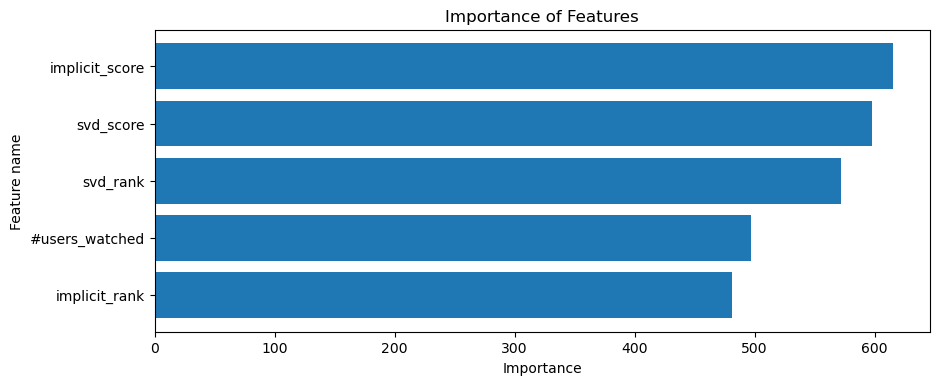

In [473]:
plot_feature_importances(features, importances)

In [471]:
importances

array([615, 481, 598, 497,   0, 572])

### First Embedding only

In [510]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature47))

In [511]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

In [512]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i], 'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'svd_rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.2811663685293966

In [513]:
lgbm_mrr, lgbm_map, rr, ap = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [514]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [515]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.281166,0.285149,0.267938,0.17635,0.167769,0.157996,0.084618,0.090826,0.075796


In [516]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'svd_rank'],
      dtype='object')
7
7


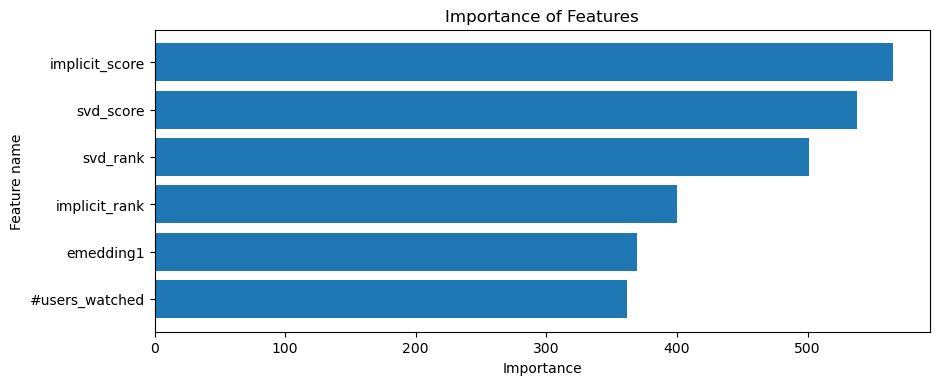

In [517]:
plot_feature_importances(features, importances)

In [518]:
importances

array([565, 400, 538, 362,   0, 369, 501])

## What is the impact of the items’rank on the effectiveness of amodel for item recommendations?

### No models' rank features

In [474]:
features = np.stack((feature1, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31]))

In [475]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

In [476]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'svd_score': feature3[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_no_rank = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.28347312798500546

In [477]:
lgbm_mrr, lgbm_map,lgbm_rr_no_rank, lgbm_ap_no_rank = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [478]:
print(st.ttest_rel(lgbm_rr_no_rank,lgbm_rr_all_features))

Ttest_relResult(statistic=-0.19944935737281705, pvalue=0.8419335098493094)


In [479]:
print(st.ttest_rel(lgbm_ap_no_rank,lgbm_ap_all_features))

Ttest_relResult(statistic=2.2577555751407328, pvalue=0.024078815418160666)


In [480]:
print(st.ttest_rel(ndcg_list_no_rank,ndcg_list_all_features))

Ttest_relResult(statistic=1.2766837337160026, pvalue=0.20187661674275845)


In [481]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [482]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.283473,0.285149,0.267938,0.175323,0.167769,0.157996,0.08882,0.090826,0.075796


In [483]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'svd_score', '#users_watched', 'new_user',
       'emedding1', 'emedding2', 'emedding3', 'emedding4', 'emedding5',
       'emedding6', 'emedding7', 'emedding8', 'emedding9', 'emedding10',
       'emedding11', 'emedding12', 'emedding13', 'emedding14', 'emedding15',
       'emedding16', 'emedding17', 'emedding18', 'emedding19', 'emedding20',
       'emedding21', 'emedding22', 'emedding23', 'emedding24', 'emedding25',
       'emedding26', 'emedding27', 'emedding28', 'emedding29', 'emedding30',
       'emedding31', 'emedding32'],
      dtype='object')
36
36


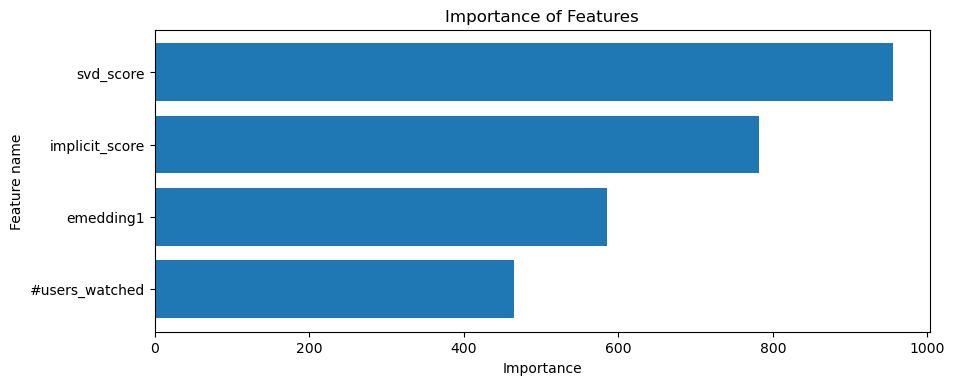

In [484]:
plot_feature_importances(features, importances)

In [485]:
importances

array([782, 955, 465,   0, 585,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

### Without Implicit Rank

In [486]:
features = np.stack((feature1, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature47))

In [487]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

In [488]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'SVD_rank':feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_no_implicit = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.28364032549151047

In [489]:
lgbm_mrr, lgbm_map, lgbm_rr_no_implicit, lgbm_ap_no_implicit = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [490]:
print(st.ttest_rel(lgbm_rr_no_implicit,lgbm_rr_all_features))

Ttest_relResult(statistic=0.5829557467177501, pvalue=0.5599952326466867)


In [491]:
print(st.ttest_rel(lgbm_ap_no_implicit,lgbm_ap_all_features))

Ttest_relResult(statistic=2.109711629580896, pvalue=0.035019255010061076)


In [492]:
print(st.ttest_rel(ndcg_list_no_implicit,ndcg_list_all_features))

Ttest_relResult(statistic=1.4384393376162414, pvalue=0.1504811813461165)


In [493]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [494]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.28364,0.285149,0.267938,0.179187,0.167769,0.157996,0.088419,0.090826,0.075796


In [495]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'svd_score', '#users_watched', 'new_user',
       'emedding1', 'emedding2', 'emedding3', 'emedding4', 'emedding5',
       'emedding6', 'emedding7', 'emedding8', 'emedding9', 'emedding10',
       'emedding11', 'emedding12', 'emedding13', 'emedding14', 'emedding15',
       'emedding16', 'emedding17', 'emedding18', 'emedding19', 'emedding20',
       'emedding21', 'emedding22', 'emedding23', 'emedding24', 'emedding25',
       'emedding26', 'emedding27', 'emedding28', 'emedding29', 'emedding30',
       'emedding31', 'emedding32', 'SVD_rank'],
      dtype='object')
37
37


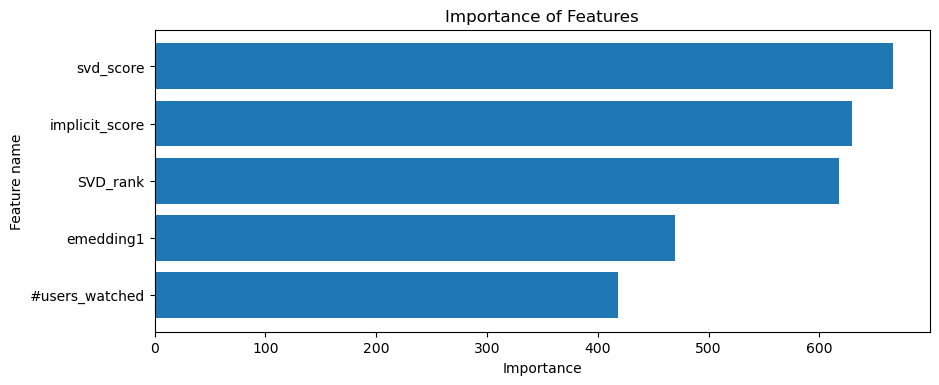

In [496]:
plot_feature_importances(features, importances)

In [497]:
importances

array([629, 666, 418,   0, 470,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 618])

### Without SVD Rank

In [498]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31]))

In [499]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

In [500]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                             'implicit_rank': feature2[i], 'svd_score': feature3[i],
                             '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
ndcg_list_no_svd = lgbm_NDCG
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.280374037600624

In [501]:
lgbm_mrr, lgbm_map, lgbm_rr_no_svd, lgbm_ap_no_svd = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [502]:
print(st.ttest_rel(lgbm_rr_no_svd,lgbm_rr_all_features))

Ttest_relResult(statistic=-1.415599472036354, pvalue=0.15706371243404443)


In [503]:
print(st.ttest_rel(lgbm_ap_no_svd,lgbm_ap_all_features))

Ttest_relResult(statistic=-0.15703605034885085, pvalue=0.8752338355493859)


In [504]:
print(st.ttest_rel(ndcg_list_no_svd,ndcg_list_all_features))

Ttest_relResult(statistic=-0.6029039537271631, pvalue=0.5466476200305761)


In [505]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [506]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.280374,0.285149,0.267938,0.170174,0.167769,0.157996,0.084418,0.090826,0.075796


In [507]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32'],
      dtype='object')
37
37


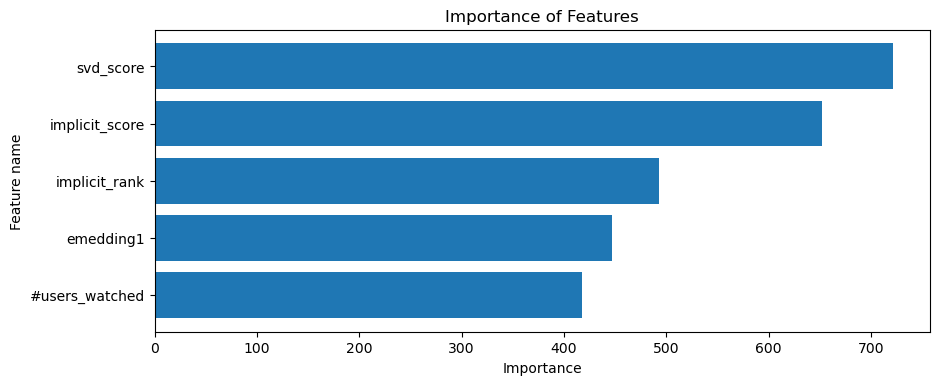

In [508]:
plot_feature_importances(features, importances)

In [509]:
importances

array([652, 493, 721, 418,   0, 447,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

## LightGBM Classifier significance test

In [533]:
print(st.ttest_rel(ifm_ap,clf_ap))

Ttest_relResult(statistic=33.4582060469903, pvalue=9.568788496518958e-192)


# Extra

## What is the impact of the baseline scores?

### No models' scores

In [192]:
features = np.stack((feature2, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature47))

In [193]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

In [194]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'IFM_rank': feature2[i],
                             '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'SVD_rank':feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.2806943628512255

In [195]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [196]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [197]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.280694,0.285149,0.267938,0.178989,0.167769,0.157996,0.083397,0.090826,0.075796


In [198]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['IFM_rank', '#users_watched', 'new_user', 'emedding1', 'emedding2',
       'emedding3', 'emedding4', 'emedding5', 'emedding6', 'emedding7',
       'emedding8', 'emedding9', 'emedding10', 'emedding11', 'emedding12',
       'emedding13', 'emedding14', 'emedding15', 'emedding16', 'emedding17',
       'emedding18', 'emedding19', 'emedding20', 'emedding21', 'emedding22',
       'emedding23', 'emedding24', 'emedding25', 'emedding26', 'emedding27',
       'emedding28', 'emedding29', 'emedding30', 'emedding31', 'emedding32',
       'SVD_rank'],
      dtype='object')
36
36


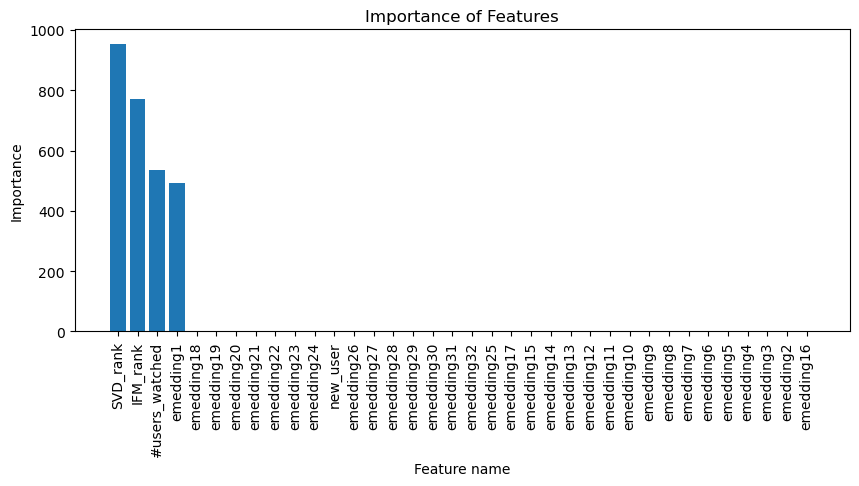

In [199]:
plot_feature_importances(features, importances)

In [200]:
importances

array([771, 535,   0, 491,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 954])

### Without IFM's score

In [229]:
features = np.stack((feature2, feature3,feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature47))

In [230]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

In [231]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'ifm_rank':feature2[i],
                         'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'SVD_rank':feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.2800660425969678

In [232]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [233]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [234]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.280066,0.285149,0.267938,0.176439,0.167769,0.157996,0.083201,0.090826,0.075796


In [235]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['ifm_rank', 'svd_score', '#users_watched', 'new_user', 'emedding1',
       'emedding2', 'emedding3', 'emedding4', 'emedding5', 'emedding6',
       'emedding7', 'emedding8', 'emedding9', 'emedding10', 'emedding11',
       'emedding12', 'emedding13', 'emedding14', 'emedding15', 'emedding16',
       'emedding17', 'emedding18', 'emedding19', 'emedding20', 'emedding21',
       'emedding22', 'emedding23', 'emedding24', 'emedding25', 'emedding26',
       'emedding27', 'emedding28', 'emedding29', 'emedding30', 'emedding31',
       'emedding32', 'SVD_rank'],
      dtype='object')
37
37


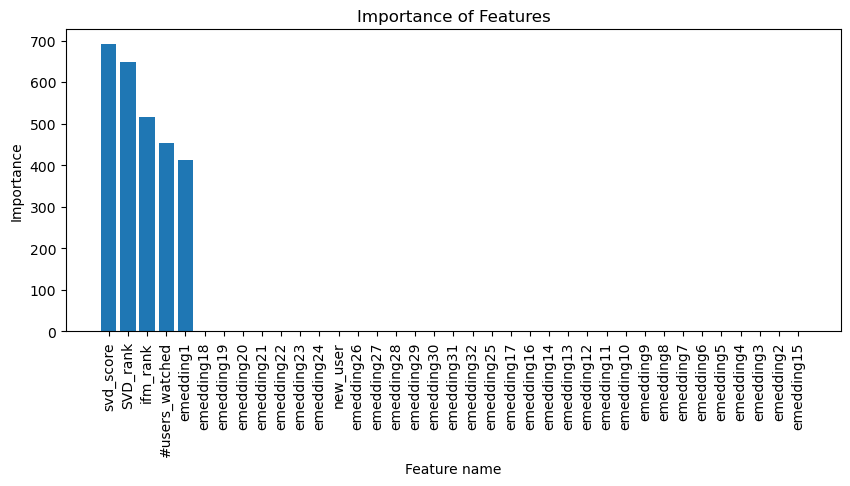

In [236]:
plot_feature_importances(features, importances)

In [209]:
importances

array([517, 692, 453,   0, 412,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 649])

### Without SVD's score

In [237]:
features = np.stack((feature1, feature2, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature47))

In [238]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

In [239]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i], 
                         'ifm_rank': feature2[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'svd_rank':feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.2805953231426194

In [240]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [241]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [242]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.280595,0.285149,0.267938,0.170515,0.167769,0.157996,0.083978,0.090826,0.075796


In [243]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'ifm_rank', '#users_watched', 'new_user', 'emedding1',
       'emedding2', 'emedding3', 'emedding4', 'emedding5', 'emedding6',
       'emedding7', 'emedding8', 'emedding9', 'emedding10', 'emedding11',
       'emedding12', 'emedding13', 'emedding14', 'emedding15', 'emedding16',
       'emedding17', 'emedding18', 'emedding19', 'emedding20', 'emedding21',
       'emedding22', 'emedding23', 'emedding24', 'emedding25', 'emedding26',
       'emedding27', 'emedding28', 'emedding29', 'emedding30', 'emedding31',
       'emedding32', 'svd_rank'],
      dtype='object')
37
37


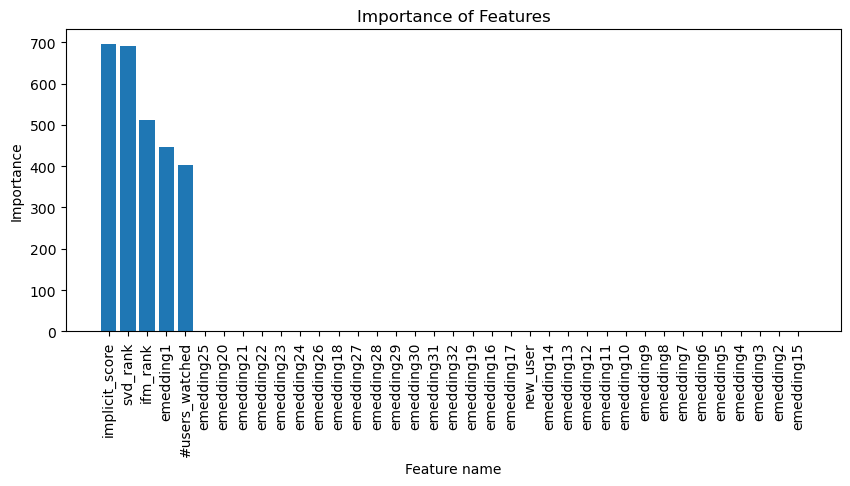

In [244]:
plot_feature_importances(features, importances)

In [218]:
importances

array([696, 511, 402,   0, 446,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 692])

## Significance Test

The difference of MAP values of two systems can identify which one is better 

In [ ]:
from scipy import stats
rvs1 = stats.norm.rvs(loc = 5,scale = 10,size = 500)
rvs2 = stats.norm.rvs(loc = 1,scale = 1,size = 5)
print(stats.ttest_ind(rvs1,rvs2))

In [ ]:
rvs2

In [ ]:
print(stats.ttest_1samp(1,2))

In [ ]:
from scipy import stats
rvs = stats.norm.rvs(loc = 5, scale = 10, size = (50,2))
print(stats.ttest_1samp(rvs,5.0))

In [ ]:
from scipy.stats import wilcoxon
d = [0.084083, 0.102764, 0.073226]
w, p = wilcoxon(d)
w, p